In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import collections

from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
train = pd.read_csv('data/train_features_nv.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')

In [3]:
train.head()

,Unnamed: 0,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,id_000644bb2,0,1,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,1,id_000779bfc,0,3,0,0.0743,0.4087,0.2991,0.0604,1.0190,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,2,id_000a6266a,0,2,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,3,id_0015fd391,0,2,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,4,id_001626bd3,0,3,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
train_g = train.filter(regex=("^g-*"))
train_c = train.filter(regex=("c-[0-9]"))

In [5]:
train_g.shape

(23814, 772)

In [6]:
train_c.shape

(23814, 100)

## try c

In [7]:
#c_model = RandomForestRegressor(random_state=1, max_depth=10, n_jobs=-1)
#c_df=train_c.values 
#target = train_targets_scored.iloc[:,1:].values
#c_model.fit(c_df,target)

In [8]:
#joblib.dump(c_model, 'model/c_rf.pkl')

In [9]:
c_model = joblib.load('model/c_rf.pkl')

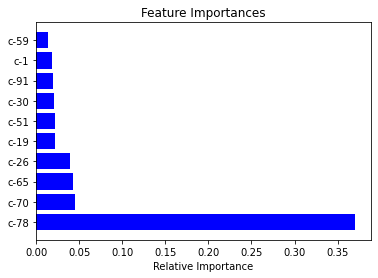

sum of importances: 0.6145487113432397


In [10]:
def plot_importances(train,model,top_num = 25):
    features =  train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances,)[-1:-top_num-1:-1] # top 25 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    print('sum of importances:',np.sum(importances[indices]))
    return(features[indices])

c_rf_colnames = set(plot_importances(train_c,c_model,top_num = 10))

In [11]:
c_names = set(train_c.columns)
c_rf_resnames = c_names - c_rf_colnames

train_c_rf = train_c.loc[:,c_rf_resnames]

In [12]:
from sklearn.decomposition import FactorAnalysis

In [13]:
#target = train_targets_scored.iloc[:,1:].values
#FA_transformer = FactorAnalysis(n_components=20, random_state=0)
#FA_transformer.fit(train_c_rf, target)
#joblib.dump(FA_transformer,'model/c_FA20.pkl')

In [14]:
c_FA10 = joblib.load('model/c_FA10.pkl')

In [15]:
train_c_FA = c_FA10.transform(train_c_rf)

## and g

In [16]:
#g_model = RandomForestRegressor(random_state=1, max_depth=10,n_jobs = -1)
#g_df=train_g.values
#target = train_targets_scored.iloc[:,1:].values
#g_model.fit(g_df,target)

In [17]:
#joblib.dump(g_model, 'model/g_rf.pkl')

In [18]:
g_model = joblib.load('model/g_rf.pkl')

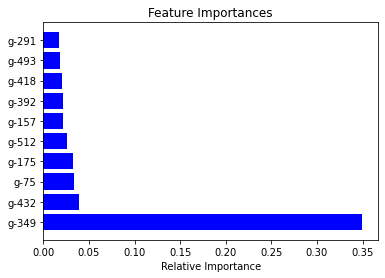

sum of importances: 0.5801153907571664


In [19]:
g_rf_colnames = set(plot_importances(train_g,g_model,top_num = 10))

In [20]:
g_names = set(train_g.columns)
g_rf_resnames = g_names - g_rf_colnames

train_g_rf = train_g.loc[:,g_rf_resnames]

In [21]:
target = train_targets_scored.iloc[:,1:].values
FA_transformer = FactorAnalysis(n_components=20, random_state=0)
FA_transformer.fit(train_g_rf, target)
joblib.dump(FA_transformer,'model/g_FA20.pkl')

['model/g_FA20.pkl']

In [22]:
g_FA20 = joblib.load('model/g_FA20.pkl')

In [23]:
train_g_FA = g_FA20.transform(train_g_rf)

# 随便跑个模型试一试

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier

In [25]:
c_rf_df = train_c.loc[:,c_rf_colnames]
g_rf_df = train_g.loc[:,g_rf_colnames]

In [26]:
xgb_train = pd.concat([train.iloc[:,[3,4,5]],c_rf_df,g_rf_df],axis= 1)

In [27]:
features = xgb_train.values
label = train_targets_scored.iloc[:,1:].values

In [28]:
features.shape

(23814, 23)

In [29]:
label.shape

(23814, 206)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=3)

In [31]:
clf_multilabel = OneVsRestClassifier(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob',num_class = 2,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1),n_jobs = -1)

In [33]:
clf_multilabel.fit(X_train[:100],y_train[:100])

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=8, min_child_weight=1,
                                            missing=None,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            nthread=None, num_class=2,
                                            num_parallel_tree=None,
                                            objective='multi:softp

In [42]:
clf_multilabel.predict_proba(X_test)[1]

array([0.        , 0.        , 0.        , 0.00466433, 0.0066676 ,
       0.        , 0.00227027, 0.        , 0.        , 0.        ,
       0.00383976, 0.        , 0.        , 0.        , 0.        ,
       0.00544489, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03324153,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00197708, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00764861,
       0.00344124, 0.        , 0.        , 0.00599813, 0.        ,
       0.        , 0.00573339, 0.        , 0.00921375, 0.00396404,
       0.        , 0.        , 0.        , 0.00482573, 0.        ,
       0.        , 0.0243742 , 0.        , 0.00243774, 0.     

In [44]:
rf_model = RandomForestRegressor(random_state=1, max_depth=10, n_jobs=-1)
rf_model.fit(X_train[:100],y_train[:100])

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=1)

In [47]:
rf_model.predict(X_train[:100])[1]

array([0.        , 0.        , 0.        , 0.01611833, 0.0236712 ,
       0.        , 0.00964869, 0.        , 0.        , 0.        ,
       0.01179271, 0.        , 0.        , 0.        , 0.        ,
       0.01038468, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00937738,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04005184, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02516722,
       0.00867675, 0.        , 0.        , 0.00407867, 0.        ,
       0.        , 0.02767968, 0.        , 0.00561084, 0.00672704,
       0.        , 0.        , 0.        , 0.00443514, 0.        ,
       0.        , 0.0299003 , 0.        , 0.00811794, 0.     